# Preview Alinas scans

The initial state of this notebook is a copy of [the notebook generated for the Stickleback project](https://github.com/habi/Sticklebacks/blob/main/PreviewScans.ipynb).

The cells below are used to set up the whole notebook.
They load needed libraries and set some default values.

In [ ]:
# Load the modules we need
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
from tqdm.auto import tqdm, trange
import pathlib
import skimage

In [ ]:
# Load our own log file parsing code
# This is loaded as a submodule to alleviate excessive copy-pasting between *all* projects we do
# See https://github.com/habi/BrukerSkyScanLogfileRuminator for details on its inner workings
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [ ]:
# # Code linting
# %load_ext pycodestyle_magic

In [ ]:
# %pycodestyle_on

In [ ]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
# We use the fast internal SSD for speed reasons
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

In [ ]:
from dask.distributed import Client
client = Client()

In [ ]:
client

In [ ]:
seaborn.set_context(context='notebook')

In [ ]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
scalefactor = 1
plt.rcParams['figure.figsize'] = (16 // scalefactor, 9 // scalefactor)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 300

In [ ]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [ ]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

Since the (tomographic) data can reside on different drives we set a folder to use below

In [ ]:
# Different locations if running either on Linux or Windows
FastSSD = True
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('N:\\')
Root = os.path.join(BasePath, 'Schmid BFH Methylcellulose')
print('We are loading all the data from %s' % Root)

Now that we are set up, actually start to load/ingest the data.

In [ ]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [ ]:
# Get *all* log files present on disk
# Using os.walk is way faster than using recursive glob.glob
# Not sorting the found logfiles is also making it quicker
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [ ]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]
Data['FolderShort'] = [folder[len(Root) + 1:] for folder in Data['Folder']]

In [ ]:
Root

In [ ]:
# Show a (small) sampler of the loaded data as a first check
Data.sample(n=5)

In [ ]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if 'TScopy' not in row.Folder and 'PR' not in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root) + 1:])

In [ ]:
# Search for .csv files in each folder.
# These are only generated when the "X/Y Alignment With a Reference Scan" was performed in NRecon.
# If those files do *not* exist we have missed to do it and should correct for this.
Data['XYAlignment'] = [glob.glob(os.path.join(f, '*T*.csv')) for f in Data['Folder']]

In [ ]:
Data

In [ ]:
# Display samples which are missing the .csv-files for the XY-alignment
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row['Folder']:
        if not row['XYAlignment']:
            if not any(x in row.LogFile for x in ['rectmp.log',  # because we only exclude temporary logfiles in a later step
                                                  'proj_nofilter',  # since these two scans of single teeth don't contain a reference scan
                                                  'TScopy',  # discard *t*hermal *s*hift data
                                                  ]):
                print('- %s has *not* been X/Y aligned' % row.LogFile[len(Root) + 1:])

In [ ]:
# Get rid of all the logfiles from all the folders that might be on disk but that we don't want to load the data from
for c, row in Data.iterrows():
    if 'proj' in os.path.split(row.Folder)[-1]:  # drop all projections folders
        Data.drop([c], inplace=True)
    if os.path.split(row.Folder)[-1] == 'PR':  # drop all phase retrieval folders for the moment
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:  # drop temporary log files of samples currently being reconstructed
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [ ]:
Data

In [ ]:
# Generate us some meaningful colums in the dataframe
Data['Sample'] = [('-').join([pathlib.Path(log).parts[-4], pathlib.Path(log).parts[-3]]) for log in Data['LogFile']]
Data['Scan'] = [os.path.basename(os.path.dirname(log)) for log in Data['LogFile']]

In [ ]:
Data

In [ ]:
# Quickly show the data from the last loaded scans
Data.tail()

In [ ]:
# Load the file names of all the reconstructions of all the scans
Data['Filenames Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
# How many reconstructions do we have?
Data['Number of reconstructions'] = [len(r) for r in Data['Filenames Reconstructions']]

In [ ]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
# Reset the dataframe count/index for easier indexing afterwards
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

In [ ]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]
Data['Camera'] = [camera(log) for log in Data['LogFile']]
Data['Filter'] = [whichfilter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Averaging'] = [averaging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [projection_size(log) for log in Data['LogFile']]
Data['RotationStep'] = [rotationstep(log) for log in Data['LogFile']]
Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [beamhardening(log) for log in Data['LogFile']]
Data['DefectPixelMasking'] = [defectpixelmasking(log) for log in Data['LogFile']]
Data['Scan date'] = [scandate(log) for log in Data['LogFile']]

----

Display the parameters we extracted from the log files (with [our log file parser](https://github.com/habi/BrukerSkyScanLogfileRuminator)) to check for consistency.

In [ ]:
for i in Data:
    print(i)

In [ ]:
Data[['Sample',
      'Voxelsize', 'Camera', 'Filter', 'Averaging', 'RotationStep',
      'RingartefactCorrection', 'BeamHardeningCorrection', 'DefectPixelMasking', 'Grayvalue']]

In [ ]:
Data[['Sample',
      'Voxelsize', 'Camera', 'Filter', 'Averaging', 'RotationStep',
      'RingartefactCorrection', 'BeamHardeningCorrection', 'DefectPixelMasking', 'Grayvalue']].to_excel('Data.xlsx')

----
Now that we've double-checked some of the parameters (and corrected any issues that might have shown up) we start to load the preview images.
If the three cells below are uncommented, the machine-generated previews are shown, otherwise we just continue.

In [ ]:
Data['Filename PreviewImage'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp')))[0] for f in Data['Folder']]
Data['PreviewImage'] = [dask_image.imread.imread(pip).squeeze()
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['Filename PreviewImage']]

In [ ]:
# Make an approximately square overview image
lines = 4

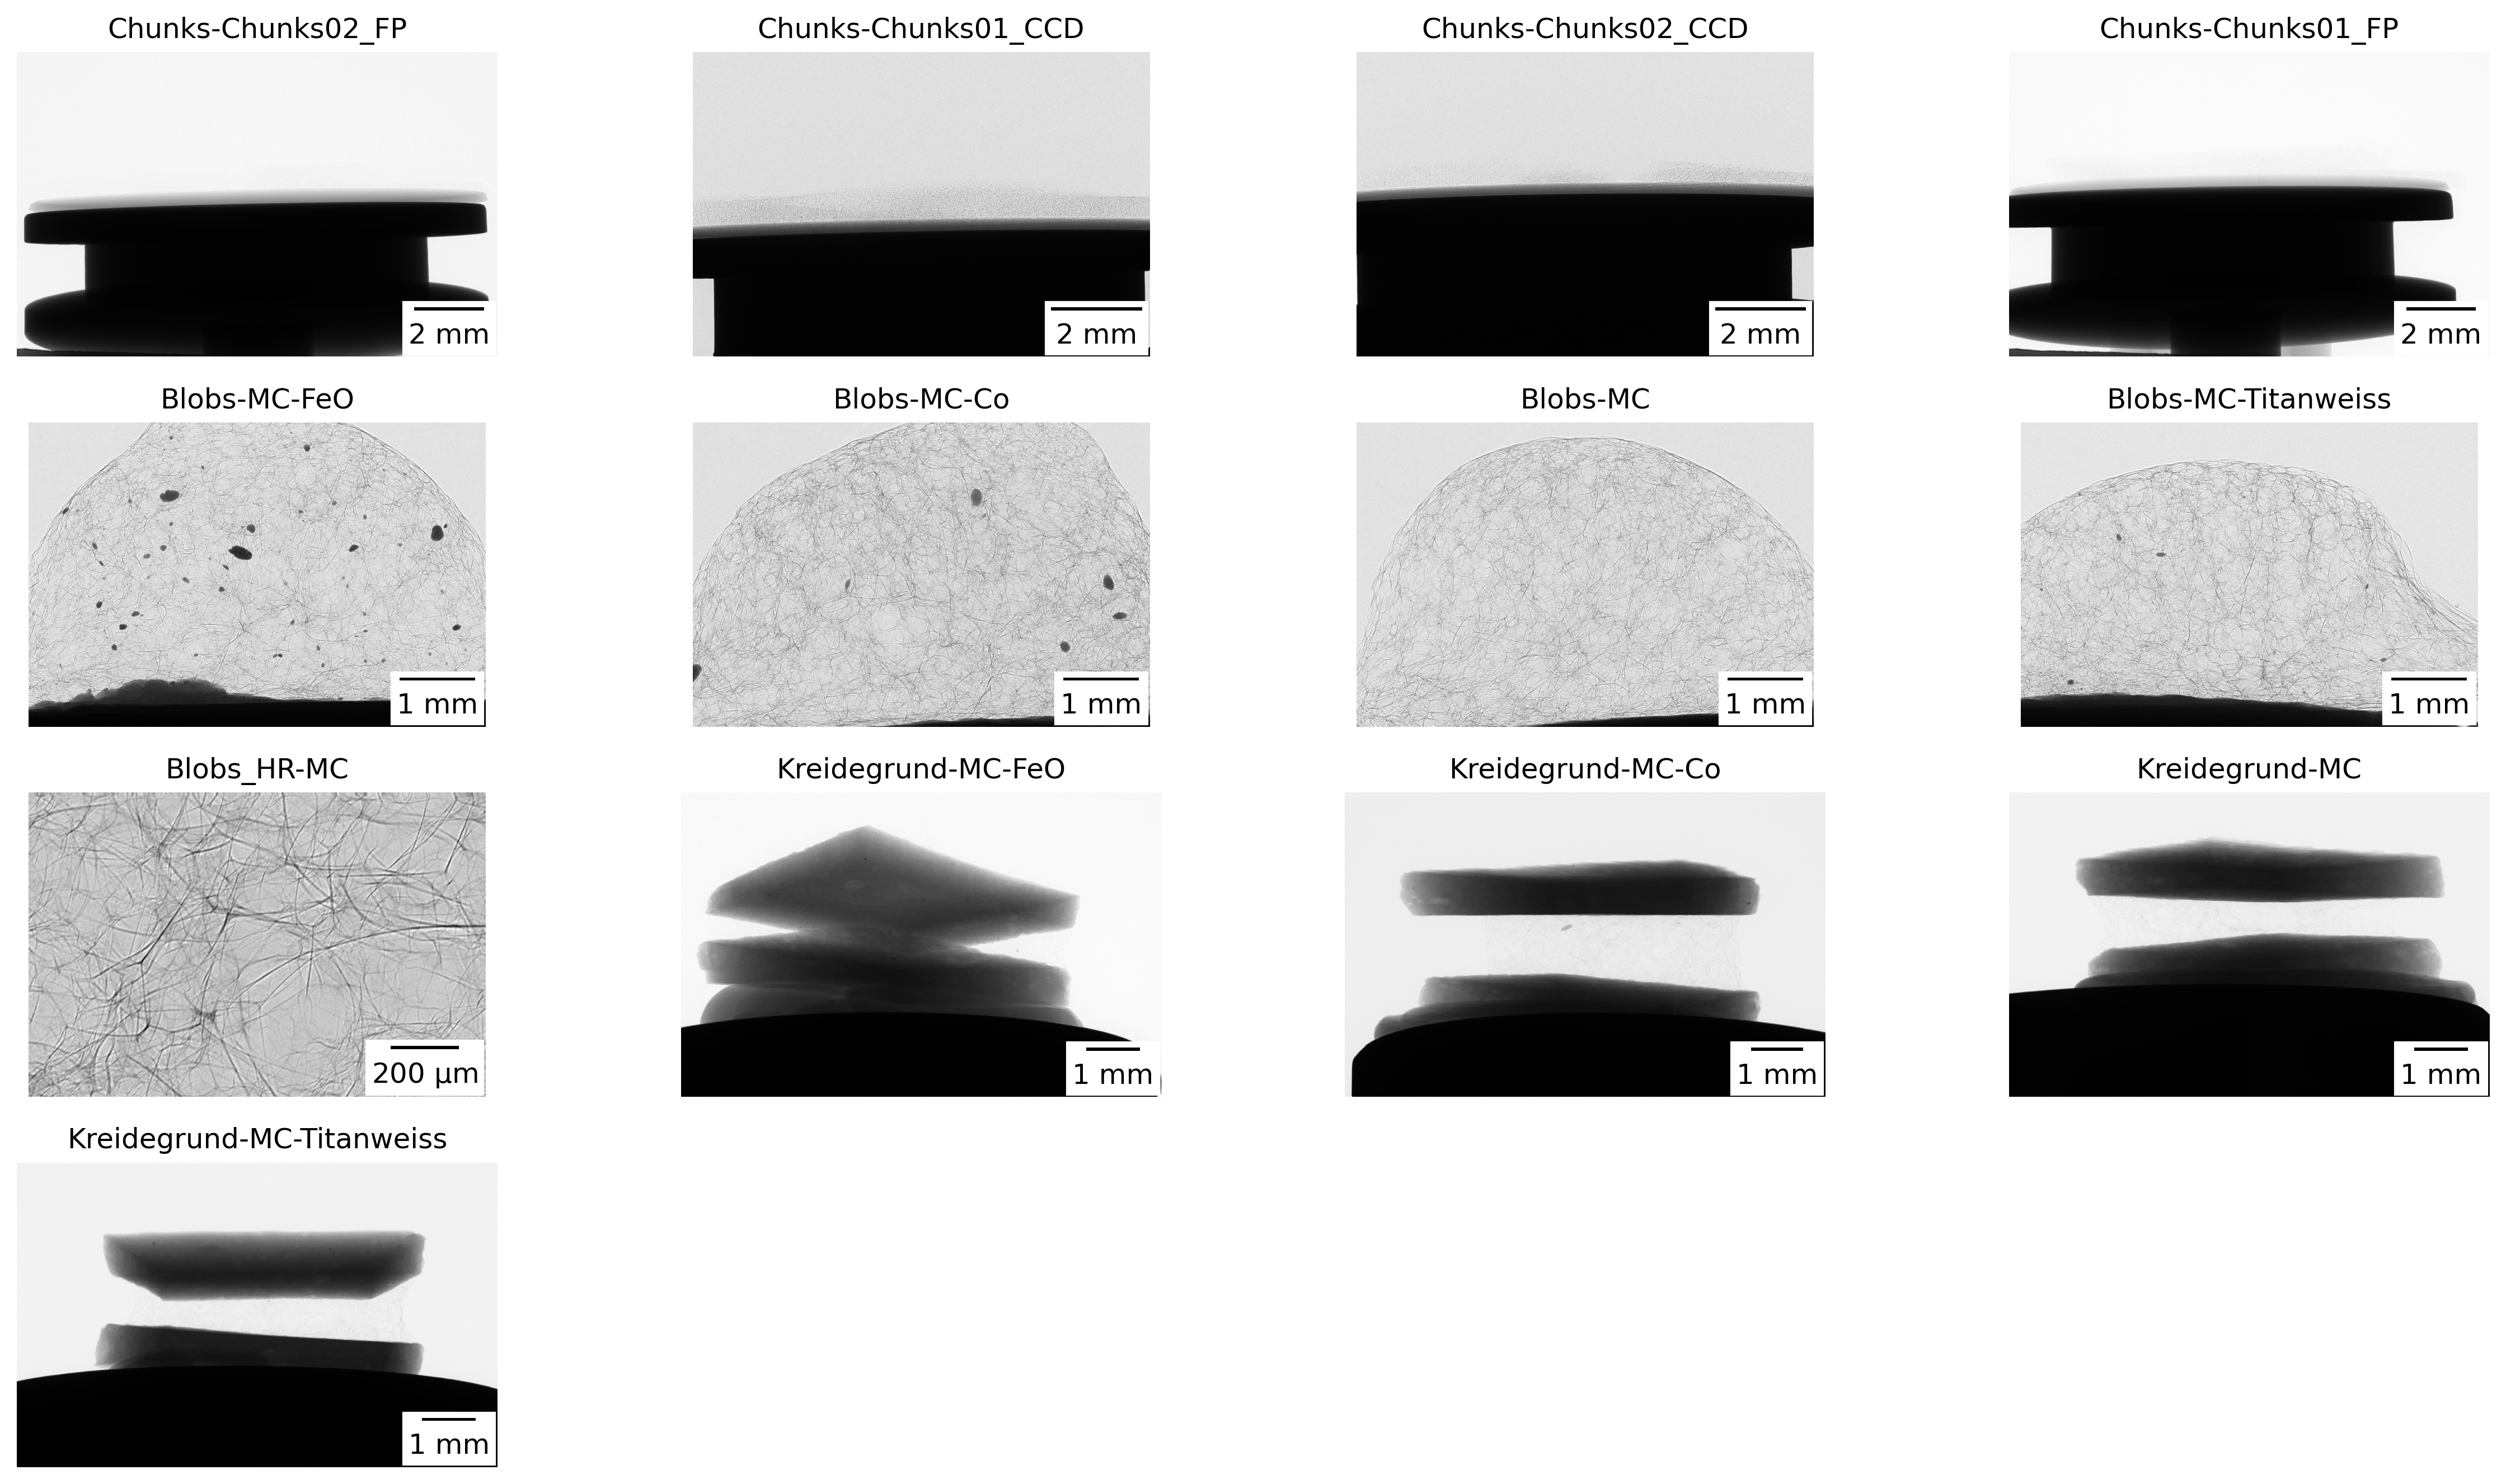

In [53]:
for c, row in Data.iterrows():
    plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
    plt.imshow(row.PreviewImage.squeeze())
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                  'um',
                                  color='black',
                                  frameon=True))
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(Root, 'ScanOverviews.png'),
            bbox_inches='tight')
plt.show()

Now we 'load' all reconstructions from disks into stacks.

In [ ]:
# # Load all reconstructions DASK arrays
# Reconstructions = [dask_image.imread.imread(os.path.join(folder,'*rec*.png')) for folder in Data['Folder']]
# Load all reconstructions into ephemereal DASK arrays, with a nice progress bar...
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Loading reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))

In [ ]:
# What do we have on disk?
print('We have %s reconstructions on %s' % (Data['Number of reconstructions'].sum(), Root))
print('This is about %s reconstructions per scan (%s scans in %s folders)' % (round(Data['Number of reconstructions'].sum() / len(Data)),
                                                                              len(Data),
                                                                              len(Data.Sample.unique())))

We have 19020 reconstructions on /media/habi/Fast_SSD/Schmid BFH Methylcellulose
This is about 1463 reconstructions per scan (13 scans in 13 folders)


In [ ]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [ ]:
# The three cardinal directions
directions = ['Axial',
              'Frontal',
              'Median']

In [ ]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(),
                   desc='Central images',
                   total=len(Data),
                   leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'],
                                             row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Center.%s.png' % (row['Sample'],
                                                            row['Scan'],
                                                            direction))
        if not os.path.exists(outfilepath):
            # Generate requested axial view
            if 'Axial' in direction:
                mid = Reconstructions[c][Data['Size'][c][0] // 2]
            if 'Frontal' in direction:
                mid = Reconstructions[c][:, Data['Size'][c][1] // 2, :]
            if 'Median' in direction:
                mid = Reconstructions[c][:, :, Data['Size'][c][2] // 2]
            # Write the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, mid[:,:,0])
        Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath).squeeze()            

In [ ]:
# Show/save middle slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving overview of central images',
                   total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.CentralSlices.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Sample'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(skimage.exposure.equalize_adapthist(row['Mid_' + direction]).squeeze())
            if d == 0:
                plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[0]))
            else:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[1] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[1]))
            plt.title('%s\nCentral %s slice' % (row['Sample'], direction.lower()))
            plt.axis('off')
        plt.savefig(outfilepath,
                    bbox_inches='tight')
        plt.show()

In [ ]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(),
                   desc='Working on MIPs',
                   total=len(Data),
                   leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'],
                                             row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Sample'],
                                                         row['Scan'],
                                                         direction))
        if not os.path.exists(outfilepath):
            # Generate MIP and write it to disk
            mip = Reconstructions[c].max(axis=d)
            imageio.imwrite(outfilepath, mip[:,:,0])
        Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()        

In [ ]:
# Show/save MIP slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving overview of MIP images',
                   total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Sample'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(skimage.exposure.equalize_adapthist(row['MIP_' + direction]).squeeze())
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s MIP' % direction)
            plt.axis('off')
            plt.title('%s\n%s MIP' % (row['Sample'], direction))
            plt.savefig(outfilepath,
                        bbox_inches='tight')
        plt.show()

For further checking the data, we look at the gray value histogram of the reconstructions.
This helps us to find scans that have not been reconstructed well and might either need to be repeated or simply re-reconstructed.

In [62]:
# Calculate the histograms of all the (subsampled) images
subsample = 5
# Caveat: dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
Data['Histogram'] = [dask.array.histogram(rec[::subsample, ::subsample, ::subsample],
                                          bins=2**8,
                                          range=[0, 2**8]) for rec in Reconstructions]
# We thus use row.Histogram[0] to plot the value below, doing the calculation only when necessary...

/tmp/ipykernel_408252/62695089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Histogram'] = [dask.array.histogram(rec[::subsample, ::subsample, ::subsample],


In [ ]:
# Plot all histograms
for c, row in Data.iterrows():
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.Histogram.png' % (row['Sample'], row['Scan']))
    if not os.path.exists(outfilepath):
        plt.semilogy(row.Histogram[0])
        plt.xlim([0, 2**8])
        plt.ylim(ymin=10**0)
        seaborn.despine()
        if subsample != 1:
            plt.title('%s\nHistogram of %s x subsampled dataset' % (row['Sample'], subsample))
        else:
            plt.title('%s Histogram' % row['Sample'])
        if not os.path.exists(outfilepath):    
            plt.savefig(outfilepath,
                        bbox_inches='tight')
        plt.show()

In [ ]:
print('We have previewed %s scans of %s folders in %s' % (len(Data),
                                                          len(Data.Sample.unique()),
                                                          Root))